# Function#1 - Scraping No.1 Hot Submission Info in r/jobs :
- Subreddit ID
- Subreddit score
- Subreddit comment numbers
- Subreddit title
- Subreddit body

In [1]:
def rscraper1():
    import praw

    import pandas as pd

    reddit = praw.Reddit(
        client_id="bfx8ExsQXjGUptX6jLA5Rg",
        client_secret="fwnSOPiCXFTv4JtKSX9iqLd3r40YcA",
        user_agent="Scraper1",
    )

    hot_posts = reddit.subreddit('Jobs').hot()

    post_list = []

    for post in hot_posts:
        post_list.append([post.id, post.score, post.num_comments, post.title, post.selftext])


    post_df = pd.DataFrame(post_list, columns=['id','score','comm_num','title','body'])

    post_df = post_df.sort_values('score',ascending=False).reset_index()
    post_df.drop(['index'], axis=1, inplace=True)
    
    top_subm_info = post_df.iloc[0].to_dict()

    return top_subm_info

# Function#2 - Getting the top comments + Extensive cleaning :
- Lower-asing
- Tokenization + Removing punctuations
- Removing stopwords
- Lemmatization

In [2]:
def rscraper2(TopSubmInfoDict):
    import praw
    from praw.models import MoreComments

    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer


    import string

    import pandas as pd
    import re

    reddit = praw.Reddit(
            client_id="bfx8ExsQXjGUptX6jLA5Rg",
            client_secret="fwnSOPiCXFTv4JtKSX9iqLd3r40YcA",
            user_agent="Scraper1",
            )

    top_id = TopSubmInfoDict['id']
    submission = reddit.submission(id=top_id)

    comment_list = []

    submission.comments.replace_more(limit=0)
    for comm in submission.comments:

        #1 - Lower-casing
        comment = comm.body.lower()

        #2 - Tokenize and removing punctuations
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        clean = tokenizer.tokenize(comment)

        #3 - Removing stopwords and singular characters
        stopword = stopwords.words('english')
        stopword = stopword + list(string.ascii_lowercase)
        word_list = []
        for word in clean:
            if word not in stopword:
                word_list.append(word)

        #4 - Lemmatization
        lemmatizer = WordNetLemmatizer()
        for w in word_list:
            comment_list.append(lemmatizer.lemmatize(w))

    return comment_list

### Mini Checkpoint : Run Scrapers and return CommList for Plotting

In [3]:
comment_list = rscraper2(rscraper1())

# Function#3 - Printing Word Frequency Line Graph

In [4]:
def rplot1(comment_list):
    from nltk.probability import FreqDist
    import matplotlib as pl
    %matplotlib inline
    import matplotlib.pyplot as plt

    fdist=FreqDist(comment_list)
    fdist.plot(20,cumulative=False)

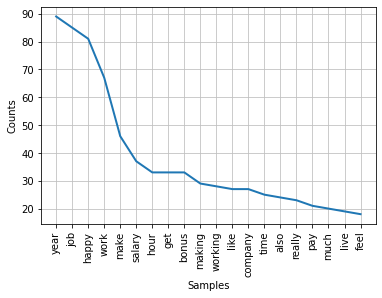

In [5]:
rplot1(comment_list)

# Fucntion#4 - Printing WordCloud

In [6]:
def rplot2(comment_list):
    from wordcloud import WordCloud, ImageColorGenerator

    import matplotlib as pl
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    import numpy as np
    
    from PIL import Image
    
    # Because WordCloud takes in string but not list
    comment_string = ' '.join(comment_list)
    
    # Mask with a RM50 bill
    mask = np.array(Image.open('./RM100.jpg')) 
    color= ImageColorGenerator(mask)
    
    # WordCloud settings
    wordcloud=WordCloud(
        background_color='white', 
        max_font_size=200,
        max_words=1000,
        mask=mask,
        random_state=42,
        repeat=True,
        )
    
    # WordCloud generator
    wordcloud.generate(comment_string)
    
    # WordCloud plotter
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(wordcloud.recolor(color_func=color), interpolation="bilinear")
    plt.show()

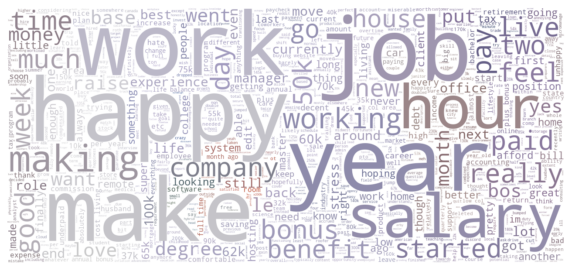

In [7]:
rplot2(comment_list)

# Function#5 - A repeating cron job tasked everyday to scrape new info :
- If the new top hot submission has a higher score than previous, output a new wordcloud
- If the existing top hot submission is still the higher score, update the word counts and reprint wordcloud.